In [1]:
from google.colab import drive #掛載雲端硬碟
drive.mount('/content/drive')  

Mounted at /content/drive


## This Notebook Demonstrates:
1. Reading the data in python, preparing it for analysis, and adjusting the labels to contain underscores
2. The code that simplfies a Raw drawing to the Simplified drawing
3. How to make a submission file with predictions in the required format

In [3]:
import os   #指定目錄位置
os.chdir("drive/MyDrive/Colab Notebooks") # to where your code and "input_my" are

In [5]:
import numpy as np #確認檔案
import pandas as pd 

print(os.listdir("./input_my")) #####
print(os.listdir("./input_my/train")) #####

['test_ans.csv', 'demo.csv', 'res.csv', 'train_raw', 'train', 'exam.csv']
['rabbit.csv', 'shoe.csv', 'scissors.csv', 'star.csv', 'sword.csv', 'The_Eiffel_Tower.csv', 'tree.csv', 'airplane.csv', 'bee.csv', 'bicycle.csv', 'butterfly.csv', 'cake.csv', 'bird.csv', 'cat.csv', 'camera.csv', 'chair.csv', 'clock.csv', 'computer.csv', 'diamond.csv', 'door.csv', 'ear.csv', 'hamburger.csv', 'guitar.csv', 'hat.csv', 'hammer.csv', 'hand.csv', 'ladder.csv', 'lion.csv', 'leaf.csv', 'pencil.csv']


In [6]:
import warnings   #引入其他套件
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import ast
import math

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Model training

In [7]:

import os #引入其他套件
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
!python -m pip install dask[bag]
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

     |████████████████████████████████| 102kB 5.5MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=25c428a72652e1b210d36e43ef36c62de1c7d303a16371cf3c1467e72ec97110
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [8]:
class_paths = glob('./input_my/train/*.csv') #引入訓練集路徑
numstonames = {i: v[17:-4].replace(" ", "_") for i, v in enumerate(class_paths)} # v[14:-4]
print(numstonames)
namestonums = {v:k for k,v in numstonames.items()}

num_classes = 30
imheight, imwidth = 64, 64  
ims_per_class = 3000 

def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.


{0: 'rabbit', 1: 'shoe', 2: 'scissors', 3: 'star', 4: 'sword', 5: 'The_Eiffel_Tower', 6: 'tree', 7: 'airplane', 8: 'bee', 9: 'bicycle', 10: 'butterfly', 11: 'cake', 12: 'bird', 13: 'cat', 14: 'camera', 15: 'chair', 16: 'clock', 17: 'computer', 18: 'diamond', 19: 'door', 20: 'ear', 21: 'hamburger', 22: 'guitar', 23: 'hat', 24: 'hammer', 25: 'hand', 26: 'ladder', 27: 'lion', 28: 'leaf', 29: 'pencil'}


In [17]:
train_grand = []   #訓練集預處理

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c,nrows = ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())
    trainarray = np.reshape(trainarray, (train.shape[0], -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
#less memory than np.concatenate
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


In [ ]:
train_grand.shape

(90000, 4097)

In [18]:
#整合訓練集

np.random.shuffle(train_grand)
y_train, X_train = train_grand[:, 0], train_grand[:, 1:]

del train_grand

valid = pd.read_csv('./input_my/res.csv',nrows = ims_per_class*30) ##### ./input/valid.csv #### res
imagebag = bag.from_sequence(valid.drawing.values).map(draw_it)
validarray = np.array(imagebag.compute())
validarray = np.reshape(validarray, (validarray.shape[0], imheight, imwidth, 1))



X_val = validarray
y_val = [namestonums[w.replace(" ", "_") ] for w in valid.word]

del valid

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

In [ ]:
y_val.shape

(500, 30)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0.]


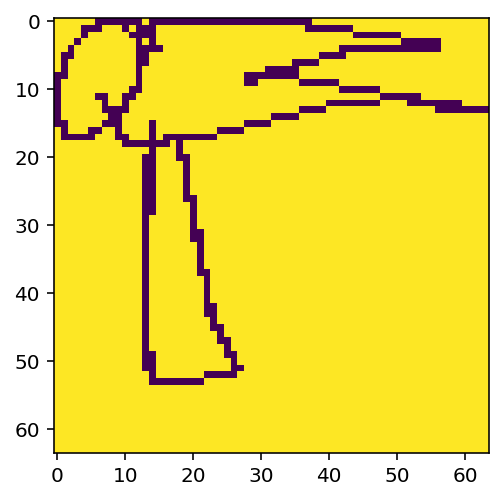

In [19]:
import matplotlib.pyplot as plt
print(y_val[0,:])
plt.imshow(X_val[0,:,:,0])
plt.show()

In [20]:
import seaborn as sns

In [21]:

valid = pd.read_csv('./input_my/res.csv',nrows = ims_per_class*3) ##### ./input/valid.csv #### res
Y_train = valid["word"]
Y_train.value_counts()

chair               32
hat                 29
hand                28
hamburger           23
diamond             22
tree                20
sword               20
shoe                19
bicycle             19
bird                19
guitar              18
cake                18
The Eiffel Tower    17
rabbit              17
bee                 16
ear                 16
leaf                15
clock               14
airplane            14
lion                13
pencil              13
star                13
butterfly           13
door                12
ladder              12
scissors            11
camera              11
hammer              10
computer             8
cat                  8
Name: word, dtype: int64

In [22]:
model = Sequential() #模型建構
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 680)              

In [23]:
import time
starttime = time.time()

In [24]:
def top_3_accuracy(x,y): #訓練!!!
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)
endtime = time.time()

Epoch 1/22
2813/2813 [==============================] - 23s 6ms/step - loss: 1.3940 - accuracy: 0.6117 - top_3_accuracy: 0.7729 - val_loss: 0.4520 - val_accuracy: 0.8640 - val_top_3_accuracy: 0.9580
Epoch 2/22
1901/2813 [===================>..........] - ETA: 5s - loss: 0.4948 - accuracy: 0.8537 - top_3_accuracy: 0.9547

KeyboardInterrupt: ignored

## Preprocessing the generating data and predict

## Save model

In [ ]:
model.save('my_model_1219.h5')

## Making a Submission

In [25]:
test = pd.read_csv('./input_my/test_ans.csv')[['drawing']]  #預測test檔案
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
testarray = np.array(imagebag.compute())
testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
testpreds = model.predict(testarray, verbose=0)
ttvs = np.argsort(-testpreds)



predict_label = [numstonames[ttvs[i][0]] for i in range(ttvs.shape[0])]

test['word'] = predict_label
test.to_csv('test_predict.csv')

In [26]:
predict_label

['ladder',
 'airplane',
 'rabbit',
 'hat',
 'hat',
 'shoe',
 'door',
 'leaf',
 'hand',
 'diamond',
 'ear',
 'ear',
 'tree',
 'airplane',
 'chair',
 'tree',
 'clock',
 'butterfly',
 'sword',
 'ear',
 'ear',
 'hammer',
 'hat',
 'clock',
 'butterfly',
 'diamond',
 'hat',
 'hamburger',
 'The_Eiffel_Tower',
 'ear',
 'clock',
 'cat',
 'guitar',
 'bicycle',
 'hat',
 'lion',
 'sword',
 'chair',
 'sword',
 'clock',
 'hamburger',
 'butterfly',
 'bicycle',
 'bird',
 'cat',
 'hamburger',
 'shoe',
 'airplane',
 'pencil',
 'diamond',
 'chair',
 'hat',
 'star',
 'bee',
 'camera',
 'hat',
 'bicycle',
 'hammer',
 'hat',
 'camera',
 'rabbit',
 'ear',
 'door',
 'door',
 'leaf',
 'computer',
 'hand',
 'ear',
 'camera',
 'bicycle',
 'bee',
 'pencil',
 'star',
 'hat',
 'hand',
 'ear',
 'chair',
 'The_Eiffel_Tower',
 'bird',
 'bird',
 'camera',
 'cake',
 'chair',
 'rabbit',
 'hamburger',
 'pencil',
 'clock',
 'butterfly',
 'camera',
 'butterfly',
 'door',
 'door',
 'clock',
 'ear',
 'cat',
 'hammer',
 'sword

In [27]:
test = pd.read_csv('./input_my/test_ans.csv')[['word']] #評估test檔案結果
count = 0
hit = 0
for i in range(len(test['word'])):
  count +=1
  if test['word'][i] == predict_label[i]:
    hit +=1
print("hit rate = %d/%d"%(hit,count))

hit rate = 170/200


In [ ]:
182/200

0.91

In [ ]:
test = pd.read_csv('./input_my/exam.csv')[['drawing']]  #做出exam預測
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
testarray = np.array(imagebag.compute())
testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
testpreds = model.predict(testarray, verbose=0)
ttvs = np.argsort(-testpreds)



predict_label = [numstonames[ttvs[i][0]] for i in range(ttvs.shape[0])]

test['word'] = predict_label
test.to_csv('exam_predict.csv')